# Data Cleaning and Feature Engineering

## Import Data

In [172]:
import pandas as pd
import numpy as np

In [173]:
# Import data

#Import train data
train_data_url = 'https://raw.githubusercontent.com/cal-dortiz/W207_Applied-_Machine_Learning/main/Final_Project/Data/train.csv'
df_train = pd.read_csv(train_data_url)

#Import test data
test_data_url = 'https://raw.githubusercontent.com/cal-dortiz/W207_Applied-_Machine_Learning/main/Final_Project/Data/test.csv'
df_test = pd.read_csv(test_data_url)

In [174]:
from sklearn.model_selection import train_test_split
use_cols=list(df_train.columns)
use_cols.remove("SalePrice")

X_train, X_test, y_train, y_test = train_test_split(df_train[use_cols],df_train["SalePrice"],
                                                    test_size=0.25,random_state=2)

X_train.shape, X_test.shape

((1095, 80), (365, 80))

## Data Cleaning

### Data Removal

Based on the exploritory data analysis, attributes that have a high amount of missing data and low impact shall be removed from the data set.

In [175]:
X_train = X_train.drop(columns=['PoolQC','MiscFeature','Alley','Fence','Id'])
X_test = X_test.drop(columns=['PoolQC','MiscFeature','Alley','Fence','Id'])

### Cleaning Housing SqFt

The EDA confirms the assumption that larger houses are correlated to highter prices. This section reviews all attributes that measure the size of the house.

The basement area is not counted as basesments may not be used in assessing property value. The correlation between 'TotalBsmtSF' and price may be due to the correlation of the size of the foundation to the size of the first floor. Keeping 'TotalBsmtSF' in the model may lead to colinearity.

In [176]:
# Removal of 'TotalBsmtSf'
X_train = X_train.drop(columns=['TotalBsmtSF'])
X_test = X_test.drop(columns=['TotalBsmtSF'])

Since square-footage of the house is highly correlated to its price, lets calculate

The data set breaks sqft and room data into basement, first floor, and seccond floor. We believe combining first and second floor room and sqft data into a single dimension will reduce the risk of colineiarity of two attributes being in the model and increase the power of the attribute.

We will leave the basement data seperate as we do not understand if the basement attributes are allowed to be used in housing assessments.

In [177]:
# Combine SqFt
X_train['TotSqFt'] = X_train['1stFlrSF'] + X_train['2ndFlrSF']
X_train = X_train.drop(columns=['1stFlrSF','2ndFlrSF'])



X_test['TotSqFt'] = X_test['1stFlrSF'] + X_test['2ndFlrSF']
X_test = X_test.drop(columns=['1stFlrSF','2ndFlrSF'])

In [178]:
X_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3Ssn

In [179]:
#Describe numerical variables
NumDataSet = X_train.select_dtypes(exclude='O')
#Describe categorical variables
CatDataSet = X_train.select_dtypes(include='O')
Categorical_Cols = CatDataSet.columns.tolist()
Categorical_Cols

Numerical_Cols = NumDataSet.columns.tolist()
Numerical_Cols 
#Within categorical variables, there are several categories that are not 
#purely nominal/unordered but insteted are ordered categories - In other
#words, they are ordinal but have text values, not numerical values. We separate
#these into a new category
Ordered_Category = CatDataSet[['ExterQual','ExterCond','BsmtQual','BsmtCond',
                   'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']].copy()
for i in Ordered_Category:
    print(Ordered_Category[i].value_counts())
    
#Remove these columns from the categorical dataset, which will now include only
#unordered categories
CatDataSet = CatDataSet.drop(['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond'], axis = 'columns')


#4.2.2 Convert all cateogrical values to numeric values
#For ordered category data, use the ordinal encoder from sklearn.
#Given a dataset with unique features, we let the encoder find the unique values per feature and transform the data to an ordinal encoding.
Ordered_Category['ExterQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['ExterCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['HeatingQC'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['KitchenQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['FireplaceQu'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
NumDataSet['GarageYrBlt'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['LotFrontage'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['MasVnrArea'].replace(to_replace=[np.nan], value=[0], inplace=True)


TA    687
Gd    357
Ex     39
Fa     12
Name: ExterQual, dtype: int64
TA    958
Gd    116
Fa     19
Po      1
Ex      1
Name: ExterCond, dtype: int64
TA    490
Gd    460
Ex     91
Fa     25
Name: BsmtQual, dtype: int64
TA    977
Gd     54
Fa     34
Po      1
Name: BsmtCond, dtype: int64
Ex    549
TA    321
Gd    187
Fa     37
Po      1
Name: HeatingQC, dtype: int64
TA    558
Gd    433
Ex     72
Fa     32
Name: KitchenQual, dtype: int64
Gd    279
TA    237
Fa     21
Po     17
Ex     14
Name: FireplaceQu, dtype: int64
TA    984
Fa     36
Gd     11
Po      1
Ex      1
Name: GarageQual, dtype: int64
TA    995
Fa     27
Gd      6
Po      4
Ex      1
Name: GarageCond, dtype: int64


C:\Users\djwei\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [180]:
#Import LabelEncoder to code categorical variables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [181]:
#For categorical data, use LabelEncoder to categorize the variables.
for col in CatDataSet:
    i = CatDataSet.columns.get_loc(col)
    CatDataSet.iloc[:,i] = CatDataSet.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')

In [182]:
# glue data sets together
X_train2 = pd.concat((CatDataSet, Ordered_Category, NumDataSet), axis=1, join='inner')

In [183]:
#Describe numerical variables
NumDataSet = X_test.select_dtypes(exclude='O')
#Describe categorical variables
CatDataSet = X_test.select_dtypes(include='O')
Categorical_Cols = CatDataSet.columns.tolist()
Categorical_Cols

Numerical_Cols = NumDataSet.columns.tolist()
Numerical_Cols 
#Within categorical variables, there are several categories that are not 
#purely nominal/unordered but insteted are ordered categories - In other
#words, they are ordinal but have text values, not numerical values. We separate
#these into a new category
Ordered_Category = CatDataSet[['ExterQual','ExterCond','BsmtQual','BsmtCond',
                   'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']].copy()
for i in Ordered_Category:
    print(Ordered_Category[i].value_counts())
    
#Remove these columns from the categorical dataset, which will now include only
#unordered categories
CatDataSet = CatDataSet.drop(['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond'], axis = 'columns')


#4.2.2 Convert all cateogrical values to numeric values
#For ordered category data, use the ordinal encoder from sklearn.
#Given a dataset with unique features, we let the encoder find the unique values per feature and transform the data to an ordinal encoding.
Ordered_Category['ExterQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['ExterCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['HeatingQC'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['KitchenQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['FireplaceQu'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
NumDataSet['GarageYrBlt'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['LotFrontage'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['MasVnrArea'].replace(to_replace=[np.nan], value=[0], inplace=True)


TA    219
Gd    131
Ex     13
Fa      2
Name: ExterQual, dtype: int64
TA    324
Gd     30
Fa      9
Ex      2
Name: ExterCond, dtype: int64
TA    159
Gd    158
Ex     30
Fa     10
Name: BsmtQual, dtype: int64
TA    334
Gd     11
Fa     11
Po      1
Name: BsmtCond, dtype: int64
Ex    192
TA    107
Gd     54
Fa     12
Name: HeatingQC, dtype: int64
TA    177
Gd    153
Ex     28
Fa      7
Name: KitchenQual, dtype: int64
Gd    101
TA     76
Fa     12
Ex     10
Po      3
Name: FireplaceQu, dtype: int64
TA    327
Fa     12
Gd      3
Ex      2
Po      2
Name: GarageQual, dtype: int64
TA    331
Fa      8
Po      3
Gd      3
Ex      1
Name: GarageCond, dtype: int64


In [184]:
#For categorical data, use LabelEncoder to categorize the variables.
for col in CatDataSet:
    i = CatDataSet.columns.get_loc(col)
    CatDataSet.iloc[:,i] = CatDataSet.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')

In [185]:
# glue data sets together
X_test2 = pd.concat((CatDataSet, Ordered_Category, NumDataSet), axis=1, join='inner')

In [188]:
#See if there are any nulls left.
X_test2.isnull().sum().sort_values(ascending = False).head(20)

TotSqFt          0
KitchenQual      0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
CentralAir       0
Electrical       0
Functional       0
GarageType       0
GarageFinish     0
PavedDrive       0
SaleType         0
SaleCondition    0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
Foundation       0
MasVnrType       0
dtype: int64

In [186]:
X_test2['BsmtFullBath'].replace(to_replace=[np.nan], value=[0], inplace=True)
X_test2['BsmtHalfBath'].replace(to_replace=[np.nan], value=[0], inplace=True)
X_test2['GarageCars'].replace(to_replace=[np.nan], value=[0], inplace=True)
X_test2['BsmtFinSF2'].replace(to_replace=[np.nan], value=[0], inplace=True)
X_test2['BsmtFinSF1'].replace(to_replace=[np.nan], value=[0], inplace=True)
X_test2['GarageArea'].replace(to_replace=[np.nan], value=[0], inplace=True)

In [191]:
y_train = np.log(y_train)


In [192]:
y_test = np.log(y_test)

In [195]:
#Show a correlation matrix with numbers
corrs = X_train2.corr('spearman')y_train.sort_values(ascending = False)

corrs_abs = corrs.abs()
sortedSeries = corrs_abs.sort_values(ascending=False)
print(sortedSeries.head(100))


SyntaxError: invalid syntax (<ipython-input-195-1de67035b8ba>, line 2)

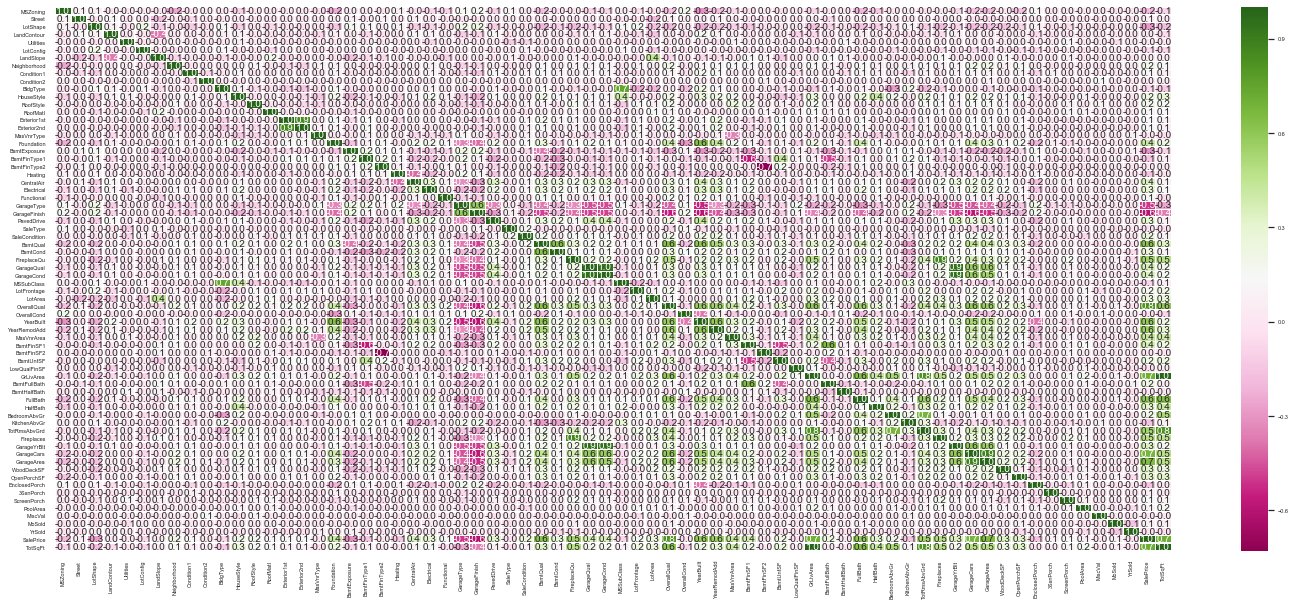

In [143]:
#View a correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
correlation_train = df_train2.corr()
sns.set(font_scale=0.5)
plt.figure(figsize=(25, 10))
ax = sns.heatmap(correlation_train, annot=True, annot_kws={'size': 10}, fmt='.1f', cmap='PiYG', linewidths=.2)
plt.show()

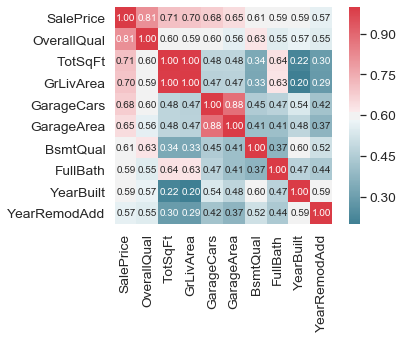

In [89]:
#Filter out 10 highest correlated categories
k = 10 
corr = df_train2.corr()
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cm = np.corrcoef(df_train2[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, annot=True, square=True, fmt='.2f', cmap=cmap,
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [144]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso

In [196]:
LR1Xtrain = pd.DataFrame(data=X_train2,columns=['OverallQual', 'TotSqFt', 'GrLivArea', 'GarageCars', 'GarageArea', 'BsmtQual', 'FullBath', 'YearBuilt', 'YearRemodAdd'])
LR1Ytrain = pd.DataFrame(data=y_train,columns=['SalePrice'])

In [197]:
LR1Xtest = pd.DataFrame(data=X_test2,columns=['OverallQual', 'TotSqFt', 'GrLivArea', 'GarageCars', 'GarageArea', 'BsmtQual', 'FullBath', 'YearBuilt', 'YearRemodAdd'])
LR1Ytest = pd.DataFrame(data=y_test,columns=['SalePrice'])

In [198]:
lr = LinearRegression()
lr.fit(LR1Xtrain, LR1Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [204]:
y_predict_test = lr.predict(LR1Xtest)

In [206]:
print("\nTesting RMSE: ")
print("Root Mean Square Error :",mean_squared_error(y_test, y_predict_test)**0.5)


Testing RMSE: 
Root Mean Square Error : 0.20817509907309958
